# Resnet18 CIFAR-10

Quantize train resnet18 without PACT

In [1]:
NOQUANT_TRAIN = False
n_epochs = 200
batches = 256
device = 'cuda:1'
mixup = True
MOD="resnet20"

In [2]:
import argparse
import os
import shutil
import time
import pandas as pd
import matplotlib.pyplot as plt
#import network.resnet_orig as resnet

from tqdm.notebook import tqdm
import time
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

DATA_DIR = "cifar100/"
print_freq = 50

# vit imsize
imsize = 32

In [3]:
# prepare labels
train_df = pd.read_csv("cifar100/train.csv")
val_df = pd.read_csv("cifar100/test.csv")
train_df

,image_id,fine_label_names,fine_labels,coarse_label_names,coarse_labels
0,19_11_100000.jpg,cattle,19,large_omnivores_and_herbivores,11
1,29_15_100001.jpg,dinosaur,29,reptiles,15
2,0_4_100002.jpg,apple,0,fruit_and_vegetables,4
3,11_14_100003.jpg,boy,11,people,14
4,1_1_100004.jpg,aquarium_fish,1,fish,1
...,...,...,...,...,...
49995,80_16_149995.jpg,squirrel,80,small_mammals,16
49996,7_7_149996.jpg,beetle,7,insects,7
49997,3_8_149997.jpg,bear,3,large_carnivores,8
49998,7_7_149998.jpg,beetle,7,insects,7


In [4]:
class cifarDataset(Dataset):
    def __init__(self,
                 df,
                 rand=False,
                 transform=None,
                 test=False
                ):

        self.df = df.reset_index(drop=True)
        self.rand = rand
        self.transform = transform
        self.test = test

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        images = cv2.imread(os.path.join(DATA_DIR, img_id))
        
        # Load labels
        label = row.fine_labels
        
        # aug
        if self.transform is not None:
            images = self.transform(image=images)['image']
              
        #images = images.astype(np.float32)
        #images /= 255
        images = images.transpose(2, 0, 1)
        
        label = label.astype(np.float32)
        #label2 = label2.astype(np.float32)
        return torch.tensor(images), torch.tensor(label),

In [5]:
import albumentations as A
import albumentations

transforms_train = albumentations.Compose([
    albumentations.ShiftScaleRotate(scale_limit=0.3, rotate_limit=180,p=0.5),
    A.Cutout(num_holes=12, max_h_size=4, max_w_size=4, fill_value=0, p=0.5),
    albumentations.HorizontalFlip(p=0.5),   
    albumentations.Resize(imsize, imsize, p=1.0), 
    albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),
])

transforms_val = albumentations.Compose([albumentations.Resize(imsize, imsize, p=1.0),
                                         albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),])

/home/ken/anaconda3/envs/pytorch/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

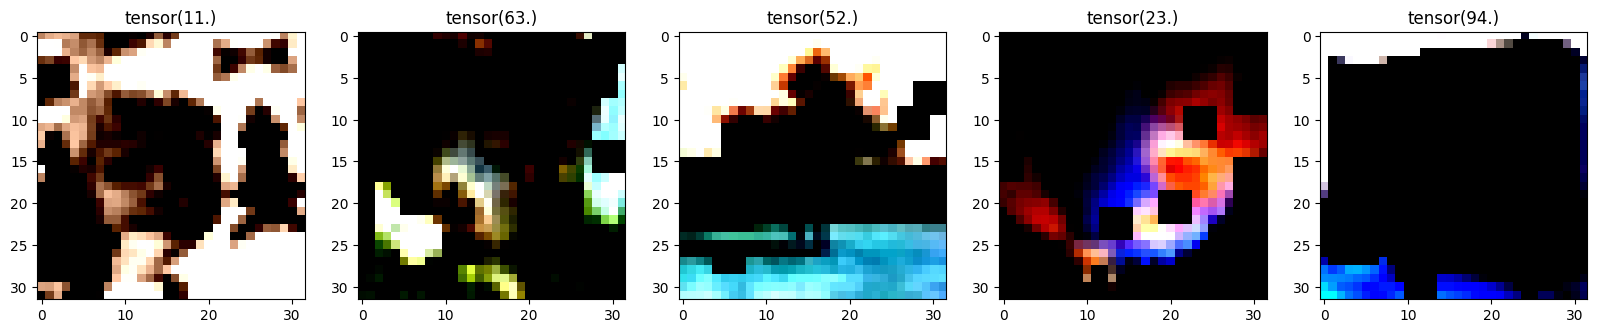

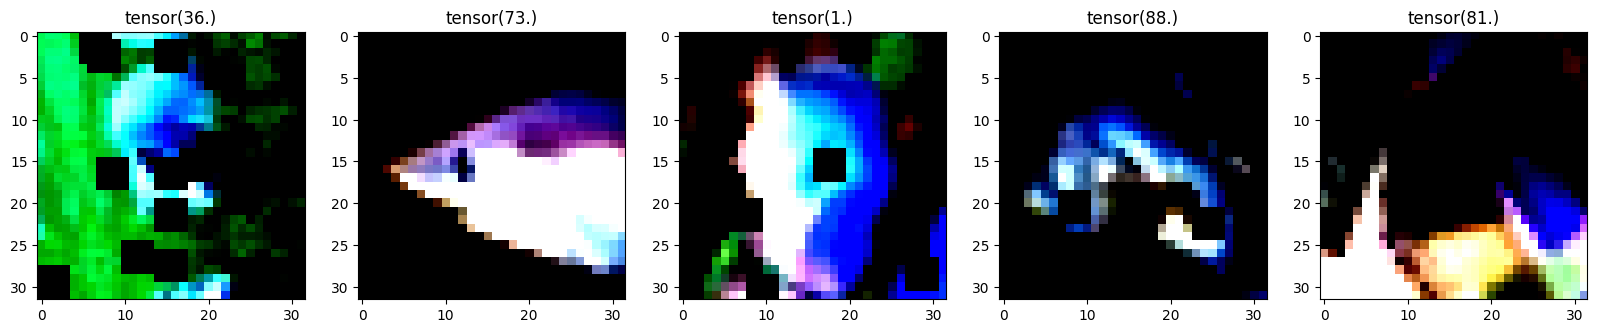

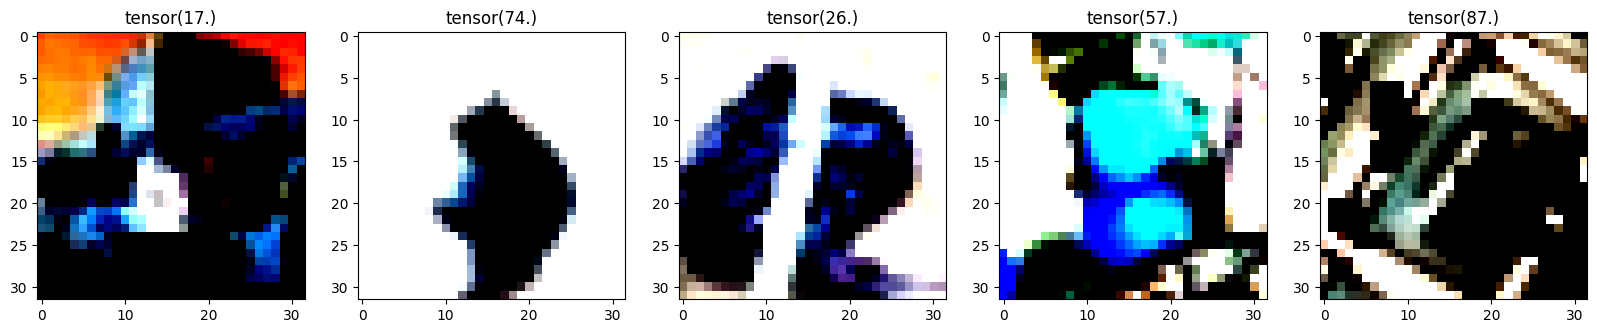

In [6]:
dataset_show = cifarDataset(train_df, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(3):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        img = img.flip(0) #BGR2RGB
        axarr[p].imshow(img.transpose(0,1).transpose(1,2))
        axarr[p].set_title(str(label))
plt.show()

In [7]:
from mixup import mixup, mixup_cross_entropy_loss


def train(train_loader, model, optimizer, epoch):
    """
        Run one train epoch
    """
    criterion = mixup_cross_entropy_loss
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    lambda_alpha = 0.002
    for i, (input, target) in enumerate(tqdm(train_loader)):

        # measure data loading time
        data_time.update(time.time() - end)

        if not mixup:
          alpha = 0
        else:
          alpha = 1
          input_var, target_var = mixup(input, target.long(), 100)
        
        input_var = input_var.to(device)
        target_var = target_var.to(device)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # L2 regularization
        l2_alpha = 0.0
        for name, param in model.named_parameters():
            if "alpha" in name:
                l2_alpha += torch.pow(param, 2)
        loss += lambda_alpha * l2_alpha

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))
        top1 = 0

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

    return losses.avg

def validate(val_loader, model):
    """
    Run evaluation
    """
    criterion = nn.CrossEntropyLoss()
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.long().to(device)
            input_var = input.to(device)
            target_var = target.to(device)

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))
    for name, param in model.named_parameters():
        if "alpha" in name:
            print(name, param.item())
    return top1.avg, losses.avg

def save_checkpoint(state, filename='checkpoint.pth'):
    """
    Save the training model
    """
    torch.save(state, filename)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [8]:
train_dataset = cifarDataset(train_df, transform=transforms_train)
val_dataset = cifarDataset(val_df, transform=transforms_val, test=True)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batches, shuffle=True,
        num_workers=8, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batches, shuffle=False,
    num_workers=8, pin_memory=True)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Variable
from pact_utils import QuantizedLinear, QuantizedConv2d, PGConv2d


def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, k=8, expansion=1):
        super(BasicBlock, self).__init__()
        self.k = k
        self.expansion = expansion
        self.conv1 = QuantizedConv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False, wbits=k, abits=k)
        self.bn1 = nn.BatchNorm2d(planes)
        # self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = QuantizedConv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False, wbits=k, abits=k)
        self.bn2 = nn.BatchNorm2d(planes)
        
        if stride != 1 or in_planes != planes:
              # original resnet shortcut
              self.shortcut = nn.Sequential(
                    # nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                    QuantizedConv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False, wbits=k, abits=k),
                    nn.BatchNorm2d(self.expansion * planes)
              )
        else: # nothing done if stride or inplanes do not differ
          self.shortcut = nn.Sequential()

    def forward(self, x):
        # Relu is implemented as the input of conv2d
        out = self.bn1(self.conv1(x))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, K=8):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.k = K

        self.conv1 = QuantizedConv2d(3, self.in_planes, kernel_size=3, stride=2, padding=1, bias=False, abits=8, wbits=8)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.alpha1 = nn.Parameter(torch.tensor(10.))
        self.layer1 = self._make_layer(block, self.in_planes, num_blocks[0], stride=1, expansion=1)
        self.layer2 = self._make_layer(block, self.in_planes*2, num_blocks[1], stride=2, expansion=1)
        self.layer3 = self._make_layer(block, self.in_planes*2, num_blocks[2], stride=2, expansion=1)
        self.layer4 = self._make_layer(block, self.in_planes*2, num_blocks[3], stride=2, expansion=1)

        # self.linear = nn.Linear(64, num_classes)
        self.linear = QuantizedLinear(self.in_planes, num_classes, abits=8, wbits=8)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride, expansion):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.k, expansion))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        # out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn1(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20(k=8):
    print("bit width:", k)
    return ResNet(BasicBlock, [2, 2, 2, 2], K=k, num_classes=100)

def resnet34(k=8):
    print("bit width:", k)
    return ResNet(BasicBlock, [3, 4, 6, 3], K=k, num_classes=100)

In [10]:
net = resnet34(8)

bit width: 8


In [11]:
net.forward(torch.rand(1,3,32,32))

tensor([[-0.0159,  0.3546, -0.5996,  2.8976, -2.3060, -1.0759, -0.4536,  1.3452,
          1.4652, -1.7920, -1.8578,  0.6756,  0.2365,  0.7441, -1.1130,  1.8619,
          1.4152, -0.2634,  2.9825,  3.5565, -2.3010, -0.0703,  1.0645, -2.0988,
          1.8941, -1.9906,  1.3196, -1.0971, -2.4036, -1.0500, -1.9198, -0.4214,
         -1.4188,  2.2801,  0.1816, -0.4762, -0.9053,  0.5614,  2.2353, -0.5695,
          1.4704,  1.4688,  2.0324,  0.1263,  0.3110, -0.3370, -1.1871, -1.7126,
         -1.1904,  2.2904,  4.2009,  0.3003,  0.5266, -0.2807,  1.3967, -0.0183,
          0.2886, -1.4284,  1.0670,  1.5692,  2.8755,  0.7976, -3.1318,  1.7201,
          0.2512, -0.8450,  0.3114, -1.3992, -0.3382, -0.8127,  0.5142, -0.5438,
         -0.3835, -1.3268,  0.8579,  1.1396, -2.7219,  0.2730,  1.8145, -1.1032,
         -0.1438,  0.6996,  0.5833, -1.9055, -0.3930, -0.1512,  1.5144, -1.0265,
         -2.3549, -0.8149, -0.0886, -0.0648,  2.5307, -1.7056,  2.4634, -1.2333,
         -1.1255,  0.8484,  

# Train with quantization

In [ ]:
from timm.scheduler import CosineLRScheduler

for k in range(6,9):
    if MOD == "resnet18" or MOD=="resnet20":
        net = resnet20(k=k)
    elif MOD=="resnet34":
        net = resnet34(k=k)

    model = net.to(device)

    # Track experiment with wandb
    import wandb
    watermark = "{}_quantize_k{}_cifar100_original".format(MOD, k)
    if mixup:
        watermark += "_mixup"

    # mess with wandb
    wandb.init(project="quantize_resnet_cifar100", name=watermark)

    # optimizer for pact
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    scheduler = CosineLRScheduler(optimizer, t_initial=n_epochs, lr_min=1e-6, 
                          warmup_t=3, warmup_lr_init=1e-6, warmup_prefix=True)

    best_prec1 = 0
    os.makedirs("models", exist_ok=True)

    for epoch in range(n_epochs):
        scheduler.step(epoch)
        # train for one epoch
        print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
        tloss = train(train_loader, model, optimizer, epoch)         

        # evaluate on validation set
        prec1, valloss = validate(val_loader, model)

        # wandb
        wandb.log({'epoch': epoch, "prec":prec1, "train_loss": tloss, 'val_loss': valloss, "lr": optimizer.param_groups[0]["lr"],})

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        print("Best prec1 : ", best_prec1)
        if is_best:
            torch.save(model.state_dict(), os.path.join(f'models/{watermark}.pth'))

bit width: 6


wandb: Currently logged in as: arutema47 (keio-csg). Use `wandb login --relogin` to force relogin


current lr 1.00000e-06


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.338 (0.338)	Loss 5.5044 (5.5044)	Prec@1 0.781 (0.781)
 * Prec@1 1.260
alpha1 9.999813079833984
Best prec1 :  1.26
current lr 3.34000e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.342 (0.342)	Loss 3.8919 (3.8919)	Prec@1 10.938 (10.938)
 * Prec@1 12.770
alpha1 9.93449592590332
Best prec1 :  12.77
current lr 6.67000e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.314 (0.314)	Loss 3.6566 (3.6566)	Prec@1 16.797 (16.797)
 * Prec@1 15.070
alpha1 9.804883003234863
Best prec1 :  15.07
current lr 1.00000e-03


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.348 (0.348)	Loss 3.6205 (3.6205)	Prec@1 17.188 (17.188)
 * Prec@1 16.160
alpha1 9.612518310546875
Best prec1 :  16.16
current lr 9.99938e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.333 (0.333)	Loss 3.3408 (3.3408)	Prec@1 20.703 (20.703)
 * Prec@1 20.930
alpha1 9.422268867492676
Best prec1 :  20.93
current lr 9.99754e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.316 (0.316)	Loss 3.0365 (3.0365)	Prec@1 28.516 (28.516)
 * Prec@1 24.070
alpha1 9.233827590942383
Best prec1 :  24.07
current lr 9.99445e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.305 (0.305)	Loss 2.9463 (2.9463)	Prec@1 23.828 (23.828)
 * Prec@1 27.160
alpha1 9.047001838684082
Best prec1 :  27.16
current lr 9.99014e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.303 (0.303)	Loss 2.8257 (2.8257)	Prec@1 30.859 (30.859)
 * Prec@1 27.710
alpha1 8.861658096313477
Best prec1 :  27.71
current lr 9.98460e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.299 (0.299)	Loss 2.6667 (2.6667)	Prec@1 33.594 (33.594)
 * Prec@1 29.780
alpha1 8.677701950073242
Best prec1 :  29.78
current lr 9.97783e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.323 (0.323)	Loss 2.6376 (2.6376)	Prec@1 36.719 (36.719)
 * Prec@1 30.790
alpha1 8.495048522949219
Best prec1 :  30.79
current lr 9.96983e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.347 (0.347)	Loss 2.7129 (2.7129)	Prec@1 37.500 (37.500)
 * Prec@1 30.880
alpha1 8.313639640808105
Best prec1 :  30.88
current lr 9.96061e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.334 (0.334)	Loss 2.5443 (2.5443)	Prec@1 36.719 (36.719)
 * Prec@1 34.170
alpha1 8.133419036865234
Best prec1 :  34.17
current lr 9.95017e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.321 (0.321)	Loss 2.5780 (2.5780)	Prec@1 37.109 (37.109)
 * Prec@1 34.420
alpha1 7.954357147216797
Best prec1 :  34.42
current lr 9.93850e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.353 (0.353)	Loss 2.4990 (2.4990)	Prec@1 38.281 (38.281)
 * Prec@1 35.490
alpha1 7.7764058113098145
Best prec1 :  35.49
current lr 9.92562e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.333 (0.333)	Loss 2.4630 (2.4630)	Prec@1 41.016 (41.016)
 * Prec@1 36.070
alpha1 7.599544525146484
Best prec1 :  36.07
current lr 9.91152e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.364 (0.364)	Loss 2.3593 (2.3593)	Prec@1 43.359 (43.359)
 * Prec@1 38.280
alpha1 7.423750877380371
Best prec1 :  38.28
current lr 9.89622e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.306 (0.306)	Loss 2.3310 (2.3310)	Prec@1 39.453 (39.453)
 * Prec@1 38.390
alpha1 7.249009132385254
Best prec1 :  38.39
current lr 9.87970e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.293 (0.293)	Loss 2.3706 (2.3706)	Prec@1 39.453 (39.453)
 * Prec@1 37.940
alpha1 7.075309753417969
Best prec1 :  38.39
current lr 9.86199e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.310 (0.310)	Loss 2.6585 (2.6585)	Prec@1 42.188 (42.188)
 * Prec@1 38.840
alpha1 6.902646541595459
Best prec1 :  38.84
current lr 9.84307e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.331 (0.331)	Loss 2.1811 (2.1811)	Prec@1 45.703 (45.703)
 * Prec@1 41.650
alpha1 6.73101806640625
Best prec1 :  41.65
current lr 9.82296e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.348 (0.348)	Loss 2.2797 (2.2797)	Prec@1 43.750 (43.750)
 * Prec@1 41.250
alpha1 6.560426712036133
Best prec1 :  41.65
current lr 9.80167e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.374 (0.374)	Loss 2.0859 (2.0859)	Prec@1 49.219 (49.219)
 * Prec@1 42.760
alpha1 6.390881061553955
Best prec1 :  42.76
current lr 9.77919e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.343 (0.343)	Loss 2.0441 (2.0441)	Prec@1 49.219 (49.219)
 * Prec@1 43.680
alpha1 6.222391605377197
Best prec1 :  43.68
current lr 9.75553e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.320 (0.320)	Loss 2.1846 (2.1846)	Prec@1 45.312 (45.312)
 * Prec@1 43.060
alpha1 6.054969310760498
Best prec1 :  43.68
current lr 9.73070e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.331 (0.331)	Loss 2.0810 (2.0810)	Prec@1 48.828 (48.828)
 * Prec@1 44.350
alpha1 5.888631820678711
Best prec1 :  44.35
current lr 9.70470e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.351 (0.351)	Loss 2.7491 (2.7491)	Prec@1 41.797 (41.797)
 * Prec@1 42.210
alpha1 5.723397731781006
Best prec1 :  44.35
current lr 9.67754e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.312 (0.312)	Loss 2.0220 (2.0220)	Prec@1 47.266 (47.266)
 * Prec@1 45.680
alpha1 5.559289455413818
Best prec1 :  45.68
current lr 9.64923e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.320 (0.320)	Loss 2.0364 (2.0364)	Prec@1 50.781 (50.781)
 * Prec@1 46.220
alpha1 5.396329879760742
Best prec1 :  46.22
current lr 9.61978e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.387 (0.387)	Loss 2.0098 (2.0098)	Prec@1 49.219 (49.219)
 * Prec@1 45.570
alpha1 5.234546661376953
Best prec1 :  46.22
current lr 9.58918e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.333 (0.333)	Loss 1.9588 (1.9588)	Prec@1 50.781 (50.781)
 * Prec@1 45.710
alpha1 5.073968410491943
Best prec1 :  46.22
current lr 9.55746e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.363 (0.363)	Loss 2.0254 (2.0254)	Prec@1 53.125 (53.125)
 * Prec@1 45.970
alpha1 4.914625644683838
Best prec1 :  46.22
current lr 9.52461e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.338 (0.338)	Loss 2.4491 (2.4491)	Prec@1 48.828 (48.828)
 * Prec@1 46.280
alpha1 4.756550312042236
Best prec1 :  46.28
current lr 9.49065e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.361 (0.361)	Loss 1.7902 (1.7902)	Prec@1 53.125 (53.125)
 * Prec@1 48.120
alpha1 4.59977912902832
Best prec1 :  48.12
current lr 9.45558e-04


  0%|          | 0/196 [00:00<?, ?it/s]

Test: [0/40]	Time 0.336 (0.336)	Loss 1.9338 (1.9338)	Prec@1 51.953 (51.953)
 * Prec@1 48.100
alpha1 4.44434928894043
Best prec1 :  48.12
current lr 9.41941e-04


  0%|          | 0/196 [00:00<?, ?it/s]